In [37]:
#This script if for investigating how deep of a circuit you can run with an IBM device using the corresponding backend noise model
import sys
import json
import numpy as np
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt

# Packages for quantum stuff
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import QAOAAnsatz
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import (
    EstimatorV2 as Estimator,
    QiskitRuntimeService,
    SamplerV2 as Sampler,
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer.noise import NoiseModel
from qiskit_ibm_runtime.fake_provider import (
    FakeBrisbane,
    FakeSherbrooke,
    FakeTorino,
)  # For simulation with realistic noise

In [ ]:
# //////////    Variables    //////////
desiredProblemType = 'Knapsack' #options: 'Knapsack'
minScale = 2 #minimum number of qubits to test
maxScale = 10 #maximum number of qubits to test
reps_p = 1

repsPerProblemScale = 100
# This is the number of times that the optimsation of parameters is repeated for each qubit number.
# This avoids issues with parameter initalisation. Should be 100 for final test

chosenBackend = 'FakeSherbrooke' #options: 'FakeBrisbane', 'FakeSherbrooke', 'FakeTorino', 'noiseless'

In [40]:
# //////////    Functions    //////////
def load_qubo_and_build_hamiltonian(file_path):
    """
    Loads QUBO terms, weights, and constant from a JSON file.
    Determines the number of qubits from the terms and constructs
    the Hamiltonian as a Qiskit SparsePauliOp.
    """
    with open(file_path, "r") as f:
        all_qubo_data = json.load(f)

    if isinstance(all_qubo_data, list):
        # If it's a list, take the first element
        qubo_data = all_qubo_data[0]
    else:
        # If it's already a dictionary, just use it directly
        qubo_data = all_qubo_data


    terms = qubo_data["terms"]
    weights = qubo_data["weights"]
    constant = qubo_data.get("constant", 0.0)
    problemType = qubo_data.get("problem_type")

    pauli_list = []
    num_qubits = 0

    if terms:
        # Flatten the list of lists and filter out empty sublists or non-integer elements
        all_indices = []
        for term_group in terms:
            if isinstance(term_group, list): # Ensure it's a list
                for idx in term_group:
                    if isinstance(idx, int): # Ensure index is an integer
                        all_indices.append(idx)

        if all_indices: # If there are any valid integer indices
            num_qubits = max(all_indices) + 1
        else: # No indices and no weights (only constant)
            num_qubits = 0
    else: # No terms at all
        num_qubits = 0
        if weights: # Weights present but no terms - problematic
            print("Warning: Weights are present, but 'terms' list is empty or missing. Cannot form Pauli operators.")

    for term_indices, weight in zip(terms, weights):
        if not term_indices or not all(isinstance(idx, int) for idx in term_indices):
            # Skip if term_indices is empty or contains non-integers
            continue

        paulis_arr = ["I"] * num_qubits
        if len(term_indices) == 1: # Linear term
            paulis_arr[term_indices[0]] = "Z"
        elif len(term_indices) == 2: # Quadratic term
            paulis_arr[term_indices[0]] = "Z"
            paulis_arr[term_indices[1]] = "Z"
        else:
            # This case should ideally not be hit if terms are only single or pairs.
            print(f"Warning: Skipping term {term_indices} with unsupported number of variables for Pauli Z construction.")
            continue
        pauli_list.append(("".join(paulis_arr)[::-1], weight))

    if not pauli_list and num_qubits > 0: # No valid Pauli terms were created, but num_qubits > 0
        cost_hamiltonian = SparsePauliOp(["I"] * num_qubits, [0]) # Zero operator on n_qubits
    elif not pauli_list and num_qubits == 0:
        cost_hamiltonian = SparsePauliOp("I", [0]) # Placeholder for 1 qubit if everything is empty
    else:
        cost_hamiltonian = SparsePauliOp.from_list(pauli_list)

    return cost_hamiltonian, constant, num_qubits, problemType

def cost_func_estimator(params, ansatz, estimator, cost_hamiltonian_logical, constant_offset, backend_total_qubits=127): # removed default for backend_total_qubits
    global numOptimisations
    prepared_observable = cost_hamiltonian_logical.apply_layout(ansatz.layout)
    pub = (ansatz, prepared_observable, [params])
    
    job = estimator.run(pubs=[pub])
    results = job.result()[0]
    cost = results.data.evs[0]

    cost_float = float(np.real(cost)) + constant_offset
    
    return cost_float

def save_results_to_json(results_dict, problem_type, minQubits, maxQubits, layers, backend_name):
    filename = f"maxDepthExperimentResults/{problem_type}_{minQubits}-{maxQubits}q_p{layers}_{backend_name}.json"
    
    with open(filename, 'w') as f:
        json.dump(results_dict, f, indent=4)

def plot_distribution_grid(results_by_qubit):
    qubit_keys = sorted(results_by_qubit.keys())
    num_plots = len(qubit_keys)
    
    cols = int(np.ceil(np.sqrt(num_plots)))
    rows = int(np.ceil(num_plots / cols))
    
    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
    axes = np.array(axes).flatten()

    for i, qubit_num in enumerate(qubit_keys):
        ax = axes[i]
        distribution = results_by_qubit[qubit_num]
        
        # To avoid unreadable, cluttered plots, we first select only the
        # top 10 most frequent results to display.
        sorted_results = sorted(distribution.items(), key=lambda item: item[1], reverse=True)[:20]
        
        # Unzip the sorted results into labels (bitstrings) and values (counts)
        if sorted_results:
            labels, values = zip(*sorted_results)
        else:
            labels, values = [], []

        # Create the bar chart
        ax.bar(labels, values, color='skyblue', edgecolor='black')
        ax.set_title(f"Distribution for {qubit_num} Qubits")
        ax.set_ylabel("Counts")
        ax.tick_params(axis='x', rotation=70) # Rotate x-labels for readability

    # 3. Clean up the figure
    # Hide any unused subplots if the grid is larger than needed
    for i in range(num_plots, len(axes)):
        axes[i].axis('off')
        
    fig.suptitle("Result Distributions vs. Problem Scale", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to make room for suptitle
    plt.show()




In [ ]:
if chosenBackend == 'FakeBrisbane':
    backend_simulator = AerSimulator.from_backend(FakeBrisbane())
elif chosenBackend == 'FakeSherbrooke':
    backend_simulator = AerSimulator.from_backend(FakeSherbrooke())
elif chosenBackend == 'FakeTorino':
    backend_simulator = AerSimulator.from_backend(FakeTorino())
elif chosenBackend == 'noiseless':
    backend_simulator = AerSimulator()

targetQubitRange = range(minScale, maxScale+1) #range of qubits to test

In [ ]:
# Training the QAOA for each problem scale and getting the best parameters for each scale achieved after 'repsPerProblemScale' runs
bestParameters = {}
for qubitNum in targetQubitRange:
    #file bizniz
    filename = f"QUBO_batches/batch_QUBO_data_{desiredProblemType}_{qubitNum}q_.json"
    print(f"Training QAOA for first QUBO in {filename}...")
    cost_hamiltonian, constant_offset, num_qubits, problem_type = load_qubo_and_build_hamiltonian(filename)
    #print(f"Number of qubits (inferred from terms): {num_qubits}")

    #circuit compilation bizniz
    circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=reps_p)
    circuit.measure_all() 
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend_simulator)
    candidate_circuit = pm.run(circuit)
    estimator = Estimator(mode=backend_simulator)
    transpiledCircuitDepth = candidate_circuit.depth()
    print(f"Transpiled circuit depth: {transpiledCircuitDepth}")

    #keeping track of parameters and associated cost function values produced so far for this problem scale
    allResults = []

    for repitition in range(1, repsPerProblemScale+1):

        #creating random inital parameters
        initial_betas = (np.random.rand(reps_p) * np.pi).tolist()
        initial_gammas = (np.random.rand(reps_p) * np.pi).tolist()
        initial_params = initial_betas + initial_gammas

        #training QAOA parameters
        #numOptimisations = 0
        print(f"\rRunning repitition {repitition}/{repsPerProblemScale} for {qubitNum} qubit {desiredProblemType} problem...", end="")
        result = minimize(
            cost_func_estimator,
            initial_params,
            args=(candidate_circuit, estimator, cost_hamiltonian, constant_offset),
            method="COBYLA",
            tol=1e-3,
            options={"maxiter": 1000}, # Adjust as needed
        )
        allResults.append([result.fun, result.x])
     
    qubitWiseBestResult = min(allResults, key=lambda item: item[0])
    qubitWiseBestParameters = qubitWiseBestResult[1]
    bestParameters[qubitNum] = {
    "transpiledDepth": transpiledCircuitDepth,
    "bestParamsForScale": qubitWiseBestParameters
}

print(f"\nBest betas and gammas for each problem scale: {bestParameters}")

Training QAOA for first QUBO in QUBO_batches/batch_QUBO_data_Knapsack_2q_.json...
Transpiled circuit depth: 21
Running repitition 1/1 for 2 qubit Knapsack problem...Training QAOA for first QUBO in QUBO_batches/batch_QUBO_data_Knapsack_3q_.json...
Transpiled circuit depth: 48
Running repitition 1/1 for 3 qubit Knapsack problem...Training QAOA for first QUBO in QUBO_batches/batch_QUBO_data_Knapsack_4q_.json...
Transpiled circuit depth: 92
Running repitition 1/1 for 4 qubit Knapsack problem...Training QAOA for first QUBO in QUBO_batches/batch_QUBO_data_Knapsack_5q_.json...
Transpiled circuit depth: 126
Running repitition 1/1 for 5 qubit Knapsack problem...Training QAOA for first QUBO in QUBO_batches/batch_QUBO_data_Knapsack_6q_.json...
Transpiled circuit depth: 176
Running repitition 1/1 for 6 qubit Knapsack problem...Training QAOA for first QUBO in QUBO_batches/batch_QUBO_data_Knapsack_7q_.json...
Transpiled circuit depth: 215
Running repitition 1/1 for 7 qubit Knapsack problem...Trainin

In [36]:
finalSamplingResults = {}
for qubitNum in targetQubitRange:
    filename = f"QUBO_batches/batch_QUBO_data_{desiredProblemType}_{qubitNum}q_.json"
    cost_hamiltonian, constant_offset, num_qubits, problem_type = load_qubo_and_build_hamiltonian(filename)
    circuit = QAOAAnsatz(cost_operator=cost_hamiltonian, reps=reps_p)
    circuit.measure_all() 
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend_simulator)
    candidate_circuit = pm.run(circuit)
    optimized_circuit = candidate_circuit.assign_parameters(bestParameters[qubitNum]["bestParamsForScale"])
    sampler = Sampler(mode=backend_simulator)
    sampler.options.default_shots = 1000

    print(f"Running final sampling for {qubitNum} qubit {desiredProblemType} problem...")
    result = sampler.run([optimized_circuit]).result()
    dist = result[0].data.meas.get_counts()
    finalSamplingResults[qubitNum] = dist


Running final sampling for 2 qubit Knapsack problem...
Running final sampling for 3 qubit Knapsack problem...
Running final sampling for 4 qubit Knapsack problem...
Running final sampling for 5 qubit Knapsack problem...
Running final sampling for 6 qubit Knapsack problem...
Running final sampling for 7 qubit Knapsack problem...
Running final sampling for 8 qubit Knapsack problem...
Running final sampling for 9 qubit Knapsack problem...
Running final sampling for 10 qubit Knapsack problem...


In [35]:
save_results_to_json(finalSamplingResults, desiredProblemType, minScale, maxScale, reps_p, chosenBackend)

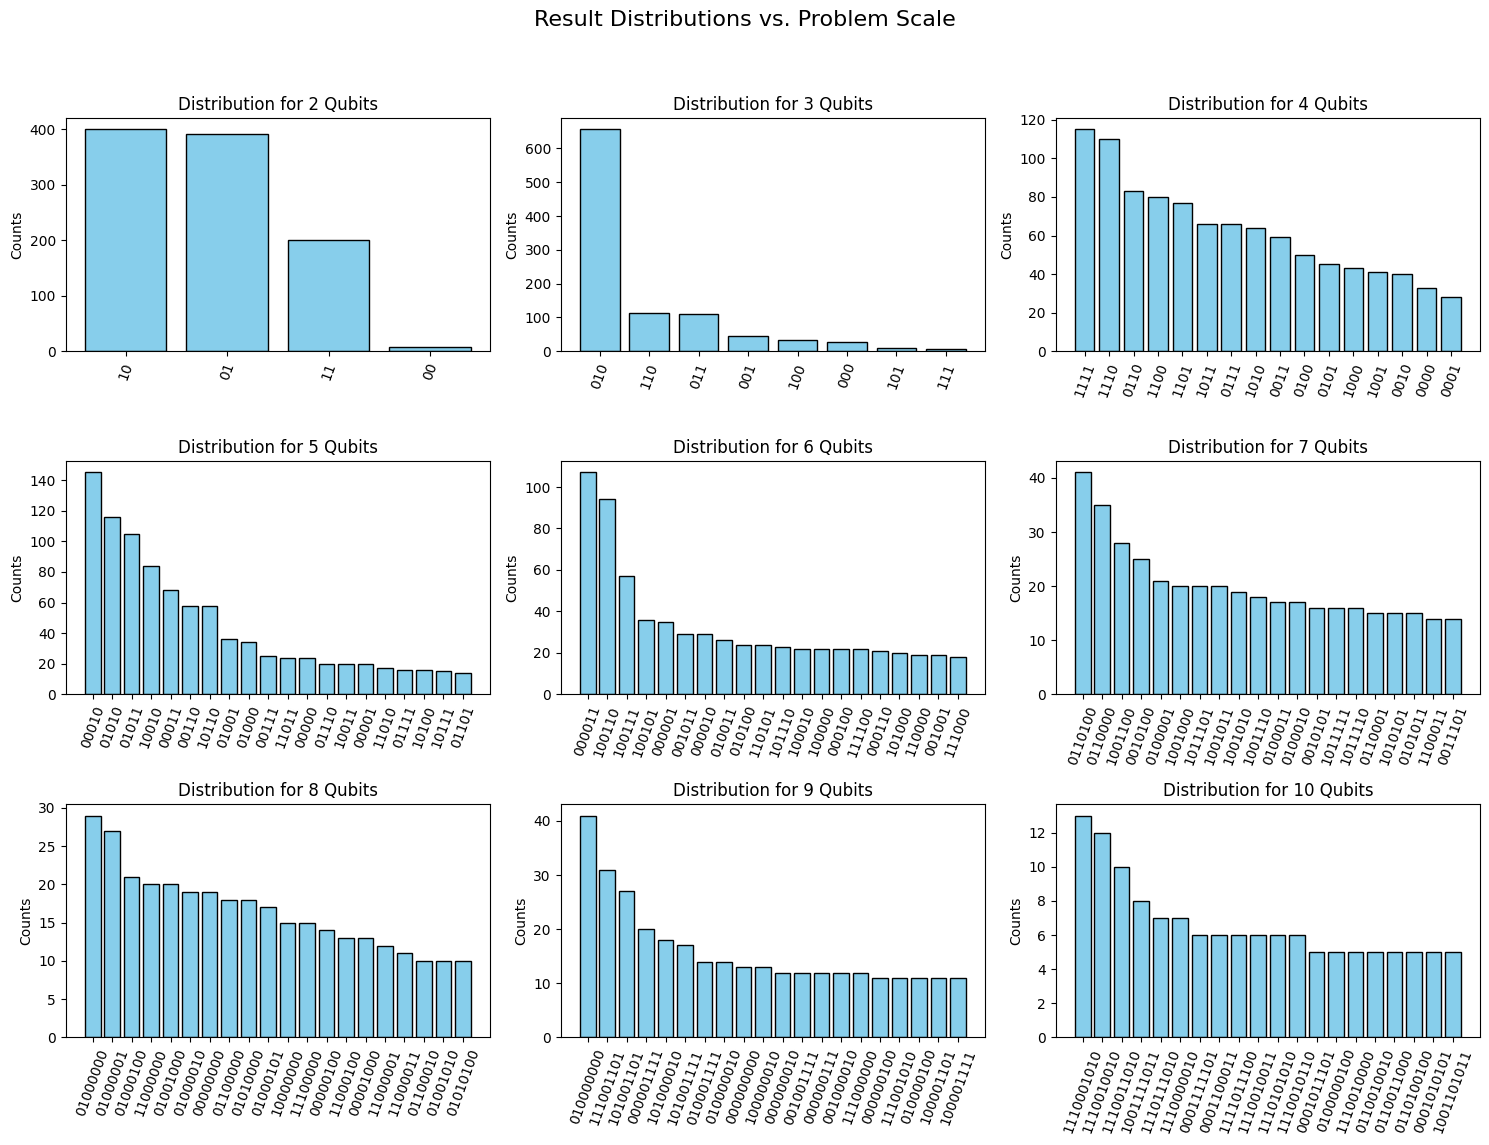

In [ ]:
dataFilename = "maxDepthExperimentResults/Knapsack_2-10q_p1_FakeSherbrooke.json"

with open(dataFilename, 'r') as f:
    data_from_json = json.load(f)

distributionsByProblemScale = {int(k): v for k, v in data_from_json.items()}

plot_distribution_grid(distributionsByProblemScale)